# Future Selection and Dimension Reduction

Data: **BBC NEWS** - the data set consist of 2,225 documents divided into 5 categories:
- business
- entertainment
- politics
- sport
- tech

D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

In [1]:
from sklearn.datasets import load_files
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [2]:
random_state = 321 
#The random_state parameter ensures that the data is shuffled in a reproducible way if it's set to a fixed number.

DATA_DIR = "/Users/davidebonaglia/Dropbox/PhD NOTES/COURSES/Utretch Summer School/Tuesday/bbc"

data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace", random_state=random_state)
df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
df

,text,label
0,Chris Evans back on the market\n\nBroadcaster ...,1
1,Giggs handed Wales leading role\n\nRyan Giggs ...,3
2,Wales silent on Grand Slam talk\n\nRhys Willia...,3
3,Kenya lift Chepkemei's suspension\n\nKenya's a...,3
4,Lee to create new film superhero\n\nComic book...,1
...,...,...
2220,Tory leader quits legal position\n\nDavid McLe...,2
2221,Buyers snap up Jet Airways' shares\n\nInvestor...,0
2222,Wright-Phillips to start on right\n\nEngland c...,3
2223,Google's toolbar sparks concern\n\nSearch engi...,4


### Print the unique target names in your data and check the number of articles in each category. 
Then split your data into training (80%) and test (20%) sets.

In [3]:
labels, counts = np.unique(df['label'], return_counts=True) 
#np.unique(data.target, return_counts=True)

In [4]:
print(labels)
print(counts)

#name of the labels
data.target_names 

[0 1 2 3 4]
[510 386 417 511 401]


['business', 'entertainment', 'politics', 'sport', 'tech']

In [5]:
print(dict(zip(data.target_names, counts)))

{'business': 510, 'entertainment': 386, 'politics': 417, 'sport': 511, 'tech': 401}


In [6]:
# We split the data into training and test

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=random_state)

### Use the CountVectorizer from sklearn and convert the text data into a document-term matrix

In [7]:
# Tokenizer to remove unwanted elements from out data like symbols
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.
# In case of memory issues, reduce the max_features value

vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=None,
                             stop_words='english',
                             ngram_range=(1, 2),
                             analyzer='word',
                             min_df=3,
                             max_features=None)

# fit_transform() does two functions: First, it fits the model and learns the vocabulary; 
# second, it transforms our data into feature vectors. 
# The input to fit_transform should be a list of strings.

bbc_dtm = vectorizer.fit_transform(X_train)
print(bbc_dtm.shape)

(1780, 23908)


Difference between CountVectorizer and tfidfVectorizer?
The only difference is that the TfidfVectorizer() returns floats while the CountVectorizer() returns ints.

### Print top 20 frequent words in the training set.

In [8]:
importance = np.argsort(np.asarray(bbc_dtm.sum(axis=0)).ravel())[::-1]
feature_names = np.array(vectorizer.get_feature_names())
feature_names[importance[:20]]

#[::-1] takes the reverse: a=1234 --> a[::-1]=4321 --> list[<start>:<stop>:<step>]

array(['said', 'mr', 'year', 'people', 'new', 'time', 'world',
       'government', 'uk', 'years', 'best', 'just', 'told', 'film',
       'make', 'game', 'like', 'music', 'labour', '000'], dtype='<U27')

In [9]:
# less used words
feature_names_2 = np.array(vectorizer.get_feature_names())
feature_names_2[importance[::-20]]

array(['00', 'deco', 'olympic bronze', ..., 'public', 'says',
       'government'], dtype='<U27')

In [10]:
#You can also sort the counts based on a document:

counts = pd.DataFrame(bbc_dtm.toarray(),
                      columns=vectorizer.get_feature_names())

# Show us the top 10 most common words in document 2
counts.T.sort_values(by=2, ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9,...,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779
retailers,0,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
figures,0,0,7,0,0,0,0,1,0,0,...,0,0,0,0,2,0,0,0,0,0
sales,0,0,6,0,0,0,0,0,0,1,...,0,0,0,4,0,0,0,0,0,0
retail,0,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
december,0,0,5,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
christmas,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ons,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
worst,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
said,6,3,4,2,0,8,2,2,0,4,...,3,6,0,5,5,3,2,4,1,1
bank england,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Filter-based feature selection

From the feature selection library in sklearn load the SelectKBest function  and apply it on the BBC dataset using the **chi-squared** method. 
Extract top 20 features.

In [11]:
X_test_vectorized = vectorizer.transform(X_test)

In [12]:
ch2 = SelectKBest(chi2, k=20)
ch2.fit_transform(bbc_dtm, y_train)

<1780x20 sparse matrix of type '<class 'numpy.int64'>'
	with 4428 stored elements in Compressed Sparse Row format>

In [13]:
feature_names_chi = [feature_names[i] for i in ch2.get_support(indices=True)]

In [14]:
feature_names_chi

['best',
 'blair',
 'brown',
 'computer',
 'digital',
 'election',
 'film',
 'government',
 'labour',
 'minister',
 'mobile',
 'mr',
 'mr blair',
 'music',
 'net',
 'party',
 'people',
 'software',
 'technology',
 'users']

Extract the 20 top features according to the **mutual** information feature selection method. 

In [15]:
mutual_info = SelectKBest(mutual_info_classif, k=20)
mutual_info.fit_transform(bbc_dtm, y_train)

<1780x20 sparse matrix of type '<class 'numpy.int64'>'
	with 6350 stored elements in Compressed Sparse Row format>

In [16]:
feature_names_mutual_info = [feature_names[i] for i in mutual_info.get_support(indices=True)]
feature_names_mutual_info

['blair',
 'coach',
 'election',
 'film',
 'firm',
 'game',
 'government',
 'labour',
 'market',
 'minister',
 'mr',
 'music',
 'party',
 'people',
 'said',
 'secretary',
 'technology',
 'tory',
 'users',
 'win']

### Embedded feature selection

One of the functions for embedded feature selection is the SelectFromModel function in sklearn. 
Use this function with L1 norm SVM and check how many non-zero coefficients left in the model.

In [18]:
print("shape of the matrix before applying the embedded feature selection:", bbc_dtm.shape)

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
model = SelectFromModel(lsvc).fit(bbc_dtm, y_train) #add threshold=0.18 as another argument to select features that have an importance of more than 0.18
X_new = model.transform(bbc_dtm)
print("shape of the matrix before applying the embedded feature selection:", X_new.shape)

shape of the matrix before applying the embedded feature selection: (1780, 23908)
shape of the matrix before applying the embedded feature selection: (1780, 156)


In [19]:
model

SelectFromModel(estimator=LinearSVC(C=0.01, dual=False, penalty='l1'))

In [20]:
# to check the values
model.estimator_.coef_

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.08073079,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

What are the top features according to the SVM model? 

In [21]:
model.get_support()

array([False,  True, False, ..., False, False, False])

In [22]:
print("Features selected by SelectFromModel: ", feature_names[model.get_support()])

Features selected by SelectFromModel:  ['000' '2004' 'airlines' 'album' 'analysts' 'apple' 'arsenal' 'athens'
 'athletics' 'award' 'ballet' 'ban' 'band' 'bank' 'bbc' 'best' 'bid'
 'blair' 'blog' 'book' 'britain' 'british' 'broadband' 'brown' 'business'
 'champion' 'chart' 'chelsea' 'chief' 'children' 'china' 'club' 'coach'
 'comedy' 'committee' 'companies' 'company' 'computer' 'content' 'council'
 'countries' 'cup' 'data' 'deal' 'deutsche' 'digital' 'dollar' 'doping'
 'drugs' 'economic' 'economy' 'education' 'election' 'england' 'european'
 'euros' 'film' 'final' 'financial' 'firm' 'firms' 'fraud' 'game' 'games'
 'gaming' 'glazer' 'good' 'government' 'great' 'group' 'growth' 'half'
 'high' 'home' 'howard' 'hunting' 'iaaf' 'including' 'information'
 'injury' 'internet' 'ireland' 'jones' 'just' 'labour' 'like' 'liverpool'
 'lord' 'mail' 'make' 'market' 'match' 'microsoft' 'million' 'minister'
 'mobile' 'mps' 'mr' 'music' 'musical' 'net' 'new' 'nintendo' 'number'
 'oil' 'old' 'olympic' 'o

### Model comparison

Create a pipeline with the tfidf representation and a random forest classifier.

In [23]:
clf1 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('classification', RandomForestClassifier())
])

Fit the pipeline on the training set.

In [24]:
clf1.fit(X_train, y_train)
#clf1.get_params()

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('classification', RandomForestClassifier())])

Use the pipeline to predict the outcome variable on your test set. 

In [25]:
y_pred1 = clf1.predict(X_test)
print(metrics.classification_report(y_test, y_pred1, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.85      0.96      0.90        92
entertainment       0.99      0.88      0.93        84
     politics       0.95      0.90      0.92        77
        sport       0.96      1.00      0.98       111
         tech       0.99      0.95      0.97        81

     accuracy                           0.94       445
    macro avg       0.95      0.94      0.94       445
 weighted avg       0.94      0.94      0.94       445



Create a second pipeline with the tfidf representation and a random forest classifier with the addition 
of an embedded feature selection using the SVM classification method with L1 penalty. 

Fit the pipeline on your training set and test it with the test set. How does the performance change?

In [26]:
clf2 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', RandomForestClassifier())
])

In [27]:
clf2.fit(X_train, y_train)
#clf2.get_params()

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', RandomForestClassifier())])

In [28]:
y_pred2 = clf2.predict(X_test)
print(metrics.classification_report(y_test, y_pred2, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.89      0.92      0.91        92
entertainment       0.95      0.89      0.92        84
     politics       0.93      0.90      0.91        77
        sport       0.96      0.98      0.97       111
         tech       0.92      0.95      0.93        81

     accuracy                           0.93       445
    macro avg       0.93      0.93      0.93       445
 weighted avg       0.93      0.93      0.93       445



Create your third and forth pipelines with the tfidf representation, a chi2 feature selection (with 20 and 200 features for clf3 and clf4, respectively), and a random forest classifier.

In [29]:
clf3 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', SelectKBest(chi2, k=20)),
    ('classification', RandomForestClassifier())
])

In [30]:
clf3.fit(X_train, y_train)
#clf3.get_params()

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 SelectKBest(k=20,
                             score_func=<function chi2 at 0x7faa31734d30>)),
                ('classification', RandomForestClassifier())])

In [31]:
y_pred3 = clf3.predict(X_test)
print(metrics.classification_report(y_test, y_pred3, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.65      0.46      0.54        92
entertainment       0.81      0.56      0.66        84
     politics       0.74      0.71      0.73        77
        sport       0.62      0.99      0.77       111
         tech       0.89      0.79      0.84        81

     accuracy                           0.71       445
    macro avg       0.74      0.70      0.71       445
 weighted avg       0.73      0.71      0.71       445



In [32]:
clf4 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', SelectKBest(chi2, k=200)),
    ('classification', RandomForestClassifier())
])

In [33]:
clf4.fit(X_train, y_train)
#clf4.get_params()

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 SelectKBest(k=200,
                             score_func=<function chi2 at 0x7faa31734d30>)),
                ('classification', RandomForestClassifier())])

In [34]:
y_pred4 = clf4.predict(X_test)
print(metrics.classification_report(y_test, y_pred4, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.84      0.92      0.88        92
entertainment       0.96      0.88      0.92        84
     politics       0.91      0.87      0.89        77
        sport       0.99      0.97      0.98       111
         tech       0.92      0.95      0.93        81

     accuracy                           0.92       445
    macro avg       0.92      0.92      0.92       445
 weighted avg       0.93      0.92      0.92       445



We can change the learner by simply plugging a different classifier object into our pipeline. 

Create your fifth pipeline with L1 norm SVM for the feature selection method and naive Bayes for the classifier. 
Compare your results on the test set with the previous pipelines.

In [35]:
clf5 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', MultinomialNB(alpha=0.01))
])

In [36]:
clf5.fit(X_train, y_train)
#clf5.get_params()

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', MultinomialNB(alpha=0.01))])

In [37]:
y_pred5 = clf5.predict(X_test)
print(metrics.classification_report(y_test, y_pred5, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.96      0.93      0.95        92
entertainment       1.00      0.94      0.97        84
     politics       0.95      0.99      0.97        77
        sport       1.00      1.00      1.00       111
         tech       0.93      0.98      0.95        81

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



### Dimension reduction - PCA

Dimensionality reduction methods such as PCA and SVD can be used to project the data into a lower dimensional space.

If you run PCA with your text data, you might end up with the message "PCA does not support sparse input. See TruncatedSVD for a possible alternative." 

Therefore, we will use the Truncated SVD function from the sklearn package and we want to find out how much of the variance in the BBC data set is explained with different components. For this, first create a tfidf matrix and use that to make a co-occurrence matrix.

In [38]:
tfidf_vect = TfidfVectorizer()
X = tfidf_vect.fit_transform(X_train)

Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
print("Shape of the TFIDF vectorizer:", X.shape)

Shape of the TFIDF vectorizer: (1780, 26739)


In [39]:
print(Xc.todense())

[[0.         0.00024418 0.         ... 0.         0.         0.        ]
 [0.00024418 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [40]:
#tfidf_vect.vocabulary_

Number of components = 1 and explained variance = 0.8302335701200946
Number of components = 2 and explained variance = 0.9165093632208314
Number of components = 4 and explained variance = 0.9291569440678306
Number of components = 5 and explained variance = 0.9344860554115801
Number of components = 10 and explained variance = 0.9477460316797051
Number of components = 15 and explained variance = 0.9529730120135865
Number of components = 20 and explained variance = 0.9560370191126828
Number of components = 50 and explained variance = 0.9645716958622752
Number of components = 75 and explained variance = 0.9683797572429518
Number of components = 100 and explained variance = 0.9711054139797324
Number of components = 200 and explained variance = 0.9777606248055699
Number of components = 500 and explained variance = 0.9865375021882168


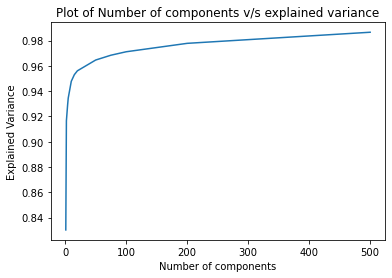

In [41]:
# list containing different values of components
n_comp = [1, 2, 4, 5, 10, 15, 20, 50, 75, 100, 200, 500]

explained = [] # explained variance ratio for each component of Truncated SVD

for x in n_comp:
    svd = TruncatedSVD(n_components=x, random_state=321)
    svd.fit(Xc)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))

plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

### How many components are needed to explain at least 95% of the variance?

Based on the selected values, it seems 15 components are needed to explain **95%** of the variance.

Use these components and train a SVM model on the BBC dataset. 
Make a pipeline for your model. Compare your results on the test set with the previous pipelines.

In [42]:
clf6 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', TruncatedSVD(n_components=15, random_state=321)),
    ('classification', LinearSVC())
])

In [43]:
clf6.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 TruncatedSVD(n_components=15, random_state=321)),
                ('classification', LinearSVC())])

In [44]:
y_pred6 = clf6.predict(X_test)
print(metrics.classification_report(y_test, y_pred6, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.91      0.92      0.92        92
entertainment       1.00      0.94      0.97        84
     politics       0.91      0.92      0.92        77
        sport       0.99      1.00      1.00       111
         tech       0.94      0.96      0.95        81

     accuracy                           0.95       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.95      0.95      0.95       445



### Plot of the accuracy of the 6 pipelines

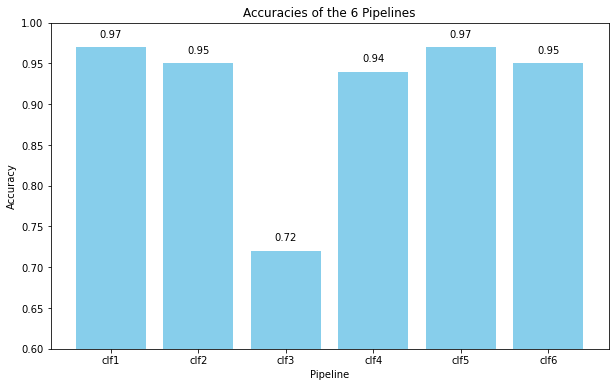

In [45]:
import matplotlib.pyplot as plt

# accuracy of each pipeline
accuracies = [0.97, 0.95, 0.72, 0.94, 0.97, 0.95]
pipeline_names = ['clf1', 'clf2', 'clf3', 'clf4', 'clf5', 'clf6']

plt.figure(figsize=(10, 6))
plt.bar(pipeline_names, accuracies, color='skyblue')
plt.xlabel('Pipeline')
plt.ylabel('Accuracy')
plt.title('Accuracies of the 6 Pipelines')
plt.ylim([0.60, 1])

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, str(v), ha='center', va='bottom')

plt.show()